In [61]:
#Run this notebook in the root directory of the project
%cd /Users/govindrnair/TheoNeuroLab/GridCellsCond


/Users/govindrnair/TheoNeuroLab/GridCellsCond


## Path integration result

In [62]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import sim_utils as s_utils
import analysis_utils as a_utils
from network_configs.instrumentations.trajectory1D import Trajectory1D
from scipy import stats
import h5py

In [63]:
def circular_error(var1,var2):

    """Calculate the circular error between two angles.

    Parameters:
        var1 (float or array-like): The first angle in radians.
        var2 (float or array-like): The second angle in radians.
    Returns:
        numpy.ndarray: The minimum absolute difference between the angles
    """
    circum = 2*np.pi
    return np.abs(np.min(np.vstack((np.abs(var1-var2),circum-np.abs(var1-var2))),axis=0))

In [68]:
sim_id='VALD-PI-TRAJ-S-m-1a'
#params=s_utils.load_sim_params(sim_id)["0"]
sim_num=0
sim_dur = float(30000)
params = s_utils.load_sim_params(sim_id)["0"]
traj = Trajectory1D(params,save_mem=False)
n_trials=1
decoded_postions = np.zeros((n_trials,int(params["sim_dur"]-traj.init_allothetic_dur)))
sim_num=0


file_path_stell = "data/VALD-PI-TRAJ-S-m-1a/stell_spks_VALD-PI-TRAJ-S-m-1a.hdf5"  # adjust path

with h5py.File(file_path_stell, "r") as f:
    print("Top-level groups:", list(f.keys()))
    for grp in f.keys():
        print(grp, "contains:", list(f[grp].keys()))


for tr in range(n_trials):
    print(tr,end=" ")
    print(sim_id,sim_num)
    stell_spks,_ = s_utils.load_spikes(sim_id,sim_num=sim_num)
    print("Success")
    decoded_postions[tr,:] = a_utils.decode_pos(stell_spks,params,win_size=40,t_start=int(traj.init_allothetic_dur))


    sim_num+=1
decoded_position_avg=stats.circmean(decoded_postions,axis=0)

std=stats.circstd(decoded_postions,axis=0)
t_ms= np.arange(traj.init_allothetic_dur,params['sim_dur'])
t_ms_idx=(t_ms/0.025).astype('int')
positions_input_ms=traj.pos_input[t_ms_idx]
velocity_input_ms=traj.vel_input[t_ms_idx]
t_s= np.linspace(traj.init_allothetic_dur/1000,(params['sim_dur']/1000),len(decoded_postions[0]))


[2.49986607e-11 4.99964287e-11 7.49933038e-11 ... 1.55506499e+00
 1.55513940e+00 1.55521534e+00]
Top-level groups: ['0']
0 contains: ['stell_spks']
0 VALD-PI-TRAJ-S-m-1a 0
Hallelujah
Stellate File Path :  data/VALD-PI-TRAJ-S-m-1a/stell_spks_VALD-PI-TRAJ-S-m-1a.hdf5
Interneuron File Path :  data/VALD-PI-TRAJ-S-m-1a/intrnrn_spks_VALD-PI-TRAJ-S-m-1a.hdf5
Success


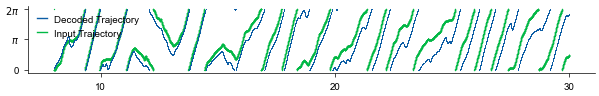

In [69]:
#Plot a scatter plot of the decoded position and the input position
from matplotlib.lines import Line2D
t_s= np.linspace(traj.init_allothetic_dur/1000,(params['sim_dur']/1000),len(decoded_postions[0]))
plt.style.use("analysis/config/paper.mplstyle")
fig,ax=plt.subplots(1,1,figsize=(7+0.313,0.87))
ax.errorbar(x=t_s,y=decoded_position_avg,yerr=std,ecolor=(119/255, 163/255, 201/255,0.25),fmt="none")
l1=ax.scatter(t_s,decoded_position_avg,label=f'Decoded Trajectory',zorder=2,s=0.5,linewidth=0)
ax.scatter(t_s,positions_input_ms,label='Input Trajectory',s=0.75,linewidth=0,c="#00B945")
ax.set_yticks(np.arange(0,2*np.pi+np.pi/2,np.pi/2))
ax.set_yticklabels(["0","$\\pi /2$","$\\pi$","$3\\pi /2$","$2 \\pi$"])
legend_elements = [Line2D([0], [0], color='#0C5DA5', lw=1, label='Decoded Trajectory'),
                   Line2D([0], [0], color='#00B945', lw=1, label='Input Trajectory')]
leg=ax.legend(handles=legend_elements, loc='best',handlelength=1,fontsize=7)
plt.draw()
yticks = ax.get_yticks()
ax.set_yticks([yticks[0],yticks[2], yticks[-1]])
xticks = ax.get_xticks()
ax.set_xticks([xticks[1],xticks[int(len(xticks)/2)], xticks[-2]])
plt.show()

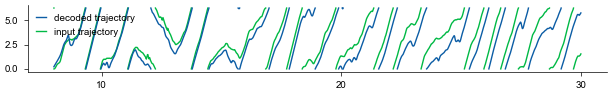

In [70]:
#Plot a line plot of the decoded position and the input position.
#Line plot allows saving the file in vector format
from matplotlib.lines import Line2D
decoded_edge_idx = [0,]
input_edge_idx = [0,]
input_unwrapped = np.unwrap(positions_input_ms)
decoded_unwrapped = np.unwrap(decoded_position_avg)
acc = 2
for i in range(len(decoded_position_avg[:-1])):
    if ((decoded_position_avg[i]<(np.pi/2)) and (decoded_position_avg[i+1]>(3*np.pi/2))) or \
        ((decoded_position_avg[i]>(3*np.pi/2)) and (decoded_position_avg[i+1]<(np.pi/2))):
        decoded_edge_idx.append(i+1)
        acc+=2
acc = 2
for i in range(len(positions_input_ms[:-1])):    
    if ((positions_input_ms[i]<(np.pi/2)) and (positions_input_ms[i+1]>(3*np.pi/2))) or \
        ((positions_input_ms[i]>(3*np.pi/2)) and (positions_input_ms[i+1]<(np.pi/2))):
        input_edge_idx.append(i+1)
        acc+=2
decoded_edge_idx = decoded_edge_idx + [-1]
input_edge_idx = input_edge_idx + [-1]
input_split = []
decoded_split = []
t_split_decoded = []
t_split_input = []

for i,val in enumerate(decoded_edge_idx[:-1]):
    decoded_split.append(decoded_position_avg[val:decoded_edge_idx[i+1]])
    t_split_decoded.append(t_s[val:decoded_edge_idx[i+1]])



for i,val in enumerate(input_edge_idx[:-1]):
    input_split.append(positions_input_ms[val:input_edge_idx[i+1]])
    t_split_input.append(t_s[val:input_edge_idx[i+1]])


plt.style.use("analysis/config/paper.mplstyle")
fig,ax=plt.subplots(1,1,figsize=(7.48,0.87))

for i,inp in enumerate(input_split):
    ax.plot(t_split_input[i],inp,label=f'input trajectory',c="#00B945",linewidth=1)



ax.errorbar(x=t_s,y=decoded_position_avg,yerr=std,ecolor=cm.Spectral(0.9),fmt="none",errorevery=10)
for i,dec in enumerate(decoded_split):
    ax.plot(t_split_decoded[i],dec,label=f'decoded trajectory',c="#0C5DA5",linewidth=1)

legend_elements = [Line2D([0], [0], color='#0C5DA5', lw=1, label='decoded trajectory'),
                   Line2D([0], [0], color='#00B945', lw=1, label='input trajectory')]
leg=ax.legend(handles=legend_elements, loc='best',handlelength=1,fontsize=7)
plt.draw()
yticks = ax.get_yticks()
ax.set_yticks([yticks[1],yticks[2], yticks[-2]])
xticks = ax.get_xticks()
ax.set_xticks([xticks[1],xticks[int(len(xticks)/2)], xticks[-2]])
plt.savefig("analysis/figures/Fig2/Fig2_C_top.svg")




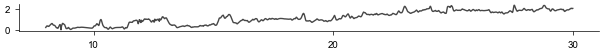

In [71]:
plt.style.use("analysis/config/paper.mplstyle")
fig,ax=plt.subplots(1,1,figsize=(7.48,0.35))
errs=np.abs(circular_error(decoded_position_avg[1:],positions_input_ms[:-1]))
ax.plot(t_s[1:],errs,c="#474747",label="Error (rad)",linewidth=1)
plt.draw()
xticks = ax.get_xticks()
ax.set_xticks([xticks[1],xticks[int(len(xticks)/2)], xticks[-2]])
plt.savefig("analysis/figures/Fig2/Fig2_C_bottom.svg")
